# PHYS20762 - Project 3: Monte Carlo (MC) Methods
# Neutron Scattering through Shielding

Student ID: 10630618

University of Manchester
February 2023

## Project Overview

A study of the implementation of the MC methods on neutron scattering was performed in this project in order to observe the interactions neutrons have with different materials. The studied materials consisted of water, lead, and graphite with their known properties used to find properties such as the rate of absorption, reflection, and transmission, along with the characteristic attenuation lengths among other specific details explained in more detail in the interactive report itself. 

As the results change with minor variations per run of the Jupyter Notebook, this overview will not give explicit results. Please refer to the table of results produced by Pandas for the explicit results.

## 1. Introduction

During World War II, scientists in the United States of America were working on the Manhattan Project in order to build an atomic bomb. In order to accomplish the task, a variety of innovations came about, one of which was the MC method which is also interchangeably referred to as the MC simulation [1].

The MC method is a powerful numerical technique that is used to predict possible outcomes of an uncertain event. It is usually applied on complex problems that require a lot of data sampling in order to get a rough idea of the behaviour of the overall system instead of the individual sample. Their applications range widely from financial modeling, traffic flow, to particle physics such as with MADGRAPH [2]. 

For the purpose of this project, the MC method will be applied in order to simulate the behaviour of neutrons scattering through an infinitely wide shielding of variable thickness, $L$ and of different materials. This is in order to study the suitability of the material as shielding to slow down neutrons bouncing around a nuclear reactor. 

## 2. Initialisation

These are necessary Python libraries that will be used to apply the MC method

In [1]:
# Import necessary libraries
import time                              # Required for measuring execution time
import numpy as np                       # Required for mathematical operations and arrays
import pandas as pd                      # Required for data manipulation and analysis
import matplotlib.pyplot as plt          # Required for data visualization
from mpl_toolkits.mplot3d import Axes3D  # Required for 3D plotting
from scipy.stats import gaussian_kde     # Required for kernel density estimation
from scipy.constants import Avogadro     # Required for Avogadro constant
from tqdm.notebook import tnrange        # Required for progress bar to track Python loop progress

# Set font size for plots
plt.rcParams.update({'font.size': 18})   # Set default font size for plots

# Use default plot style
plt.style.use('default')# Use default plot style

# Start time for timing the code
start_time = time.time()

## 3. Finding a good Random Number Generator (RNG)
In order to use the MC method, a suitable RNG must be used in order to provide a set of random data that can be sampled. A computer will never provide true random numbers as no number produced by a mathematical operation is truly random. A more accurate name for RNGs using computers is Pseudo Random Number Generator (PRNG) which is an algorithm based on mathematical equations which creates a set of values that are statistically indistinguishable from a set of real random values.

### 3.1 Checking Python's in-built Pseudo Random Number Generator (PRNG): numpy.random.uniform

Python's numpy library contains one such PRNG known as np.random.uniform. 

The Probability Density Function (PDF) for numpy.random.uniform() is:
<br><center> $P(x) = \frac{1}{b-a} $,</center> 

where $a$ and $b$ are the range of values that the in-built function is allowed to generate values from.

The default value will be for $a = 0$ and $b = 1$.

We can test for its uniform randomness by plotting $10,000$ random points generated by numpy.random.uniform on a 3D interactive diagram. 

The diagram will be color coded to provide an overview of the density of points across the shape. This means that if the shade of the colors are roughly evenly distributed, the distribution of points will also be even, and hence the random number generator will be shown as reliable. <b>Green</b> means dense, <b>blue</b> means less dense.

The plot will been left interactive in order to check the randomness in all 3 planes. Please rotate the plot as you see fit. 

<IPython.core.display.Javascript object>


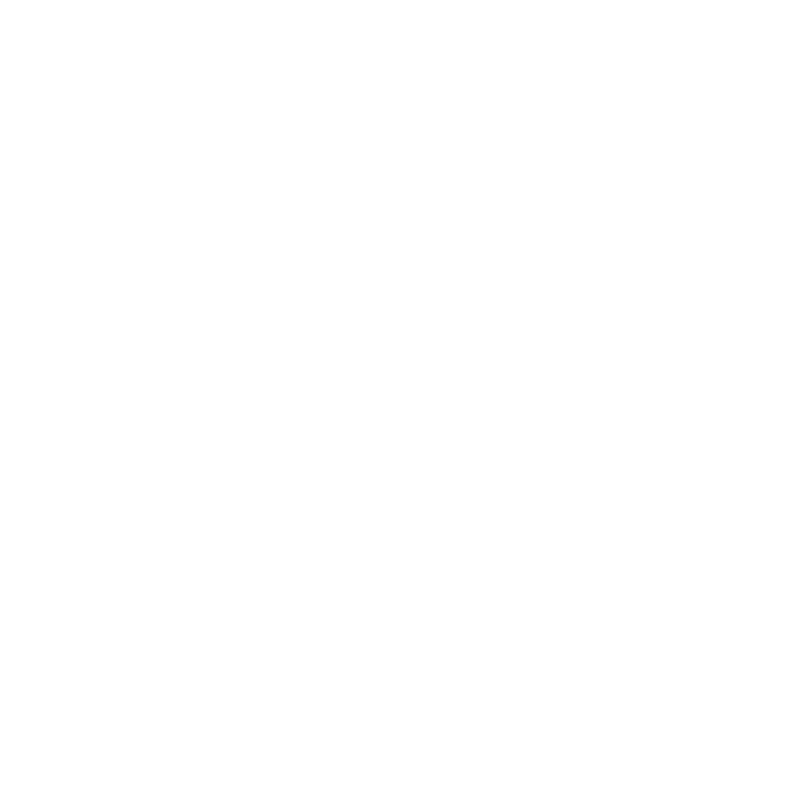

In [2]:
# Magic command to enable interactive plots in Jupyter notebooks
%matplotlib notebook 

def randomiser_of_n(n):
    """
    Generate n random numbers between 0 and 1 for x, y and z coordinates respectively
    
    Args:
    n: Number of random points to be generated
    
    Returns:
    x, y, z: Numpy arrays with n randomly generated points for x, y and z coordinates
    """
    x = np.random.uniform(size=n) #Define a dynamic array for the x-component of the plot
    y = np.random.uniform(size=n) #Define a dynamic array for the y-component of the plot
    z = np.random.uniform(size=n) #Define a dynamic array for the z-component of the plot

    return x, y, z

def plot():
    """
    Generate a 3D scatter plot of 10,000 randomly generated points with color coding based on density
    The lighter color indicates a higher density of points relative to the darker areas of the plot
    
    Args:
    None
    
    Returns:
    None
    """
    # Generate 10,000 random points for x, y, and z coordinates
    x, y, z = randomiser_of_n(10000)
    
    # Stack the x, y, and z points into a single array
    points = np.vstack((x, y, z))
    
    # Get the color of each point based on its density
    density_function = gaussian_kde(points)
    
    # Get the color of each point based on its density
    colors = density_function(points)
    
    # Set up the 3D plot
    fig = plt.figure(figsize=(7, 7))
    ax = Axes3D(fig)
    
    # Create the scatter plot with color coding
    ax.scatter(x, y, z, c=colors)
    
    # Add axis labels
    ax.set_xlabel('X Values')
    ax.set_ylabel('Y Values')
    ax.set_zlabel('Z Values')
    
    # Show the plot
    plt.show()
    
# Call the plot function to generate and display the plot
plot()

As can be seen, the data samples produced show an even distribution of points due to the even spread of colors in all directions. Therefore, numpy.random.uniform will be a reliable PRNG to apply in the MC method.

### 3.2 Checking International Business Machines's (IBM) PRNG: RANDScientific Subroutine Package (RANDSSP)

Another PRNG that was considered was IBM's version of PRNGs called RANDSSP. It is a type of PRNG called the Linear Congruential Generator (LCG). Although it is simple and efficient, it exhibits biases known as spectral problems or hyperlanes. Spectral problems are undesirable patterns or correlations in the generated sequence of pseudorandom numbers. They are biases that arise due to the  deterministic nature of initial seed values that are fed into the LCG. 

This is present in the function of the LCG,

$$X_{n+1} = (aX_{n}+c) mod (m) \quad$$

with 
$$0 < m,$$
$$0 \leq a < m,$$
$$0< c < m,$$
$$0 \leq X_{0} < m$$

as the conditions that determine the values produced.

The initial seed value is given as $X_0$, for increment $c$, multiplier $a$, modulus $m$, and where $(aX_{n}+c) mod (m)$ represents the "modulo" function of $aX_{n}+c$ and $m$, returning the remainder of 
$$\frac{aX_{n}+c}{m}$$.

The gradient of the remainder, 
$$s= \frac{X_n}{m},$$

is the random number generated at the end of an LCG calculation.

This function is simple to make, but due to said possible biases, np.random.uniform was chosen over RANDSSP as the PRNG of choice in the MC method. This will be better seen when the RANDSSP is applied to generate a large number of random points like section 3.1.

The exception for when the LCG is useful is if the simulation we are making does not matter on the spectral problems [3].

Just as in section 3.1, the plot will be interactive to allow for a full check of the plot.

<IPython.core.display.Javascript object>


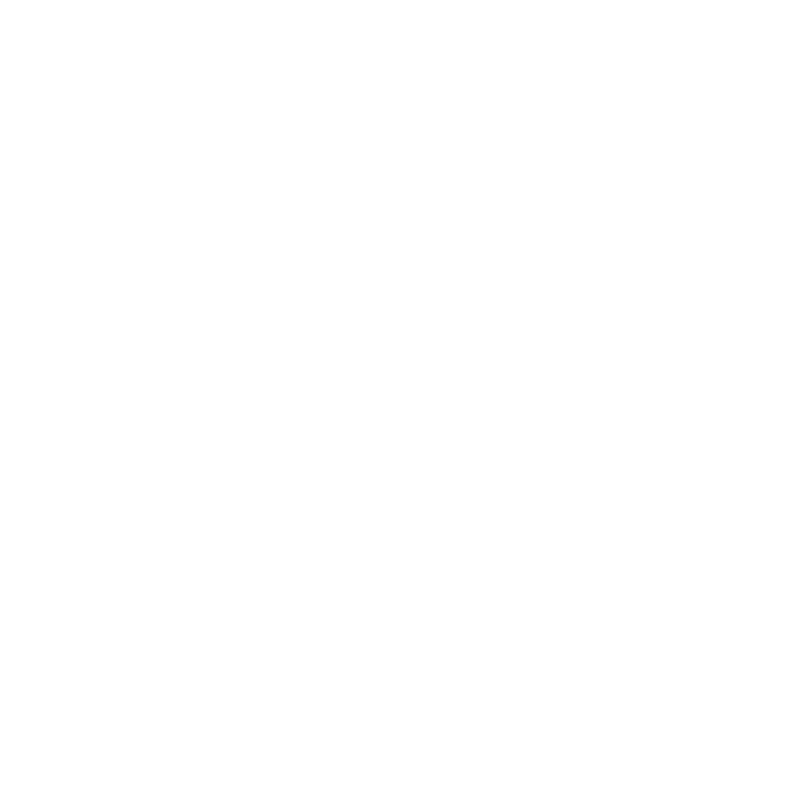

In [3]:
def randssp(p, q):
    """
    
    RANDSSP Multiplicative congruential uniform random number generator.

    Based on the parameters used by IBM's Scientific Subroutine Package,
    this function generates an m-by-n random matrix using the "bad"
    generator parameters that IBM used in several libraries in the 1960's.
    There is a strong serial correlation between three consecutive values.

    The function can only accept the parameters m and n to generate the
    random matrix. It uses the global variables m, a, c, and x to generate
    the random numbers. These values are initialized when the function is
    called for the first time.

    In coding terms, it returns a matrix of shape (p, q) of pseudorandom numbers between 0 and 1
    using the linear congruential method with the parameters m=2**31, a=2**16+3, c=0,
    and seed value x=123456789. If p or q is not provided, defaults to p=1 and q=p.
    
    Args:
    p (int): Number of rows in the generated matrix (default 1).
    q (int): Number of columns in the generated matrix (default p).

    Returns:
    r (numpy.ndarray): An m-by-n random matrix.
    """
    # Define global variables
    global m, a, c, x
    
    # Initialize the global parameters if they haven't been initialized before
    try:
        x
    except NameError:
        m = pow(2, 31)
        a = pow(2, 16) + 3
        c = 0
        x = 123456789
    
    # Use default values if p or q are not provided
    try:
        p
    except NameError:
        p = 1
    try:
        q
    except NameError:
        q = p
    
    r = np.zeros([p, q])

    for l in range(0, q):
        for k in range(0, p):
            x = np.mod(a*x + c, m)
            r[k, l] = x / m
    
    return r

# Generate a 5x10000 matrix of pseudorandom numbers
k = randssp(3, 10000)

# Calculate the Gaussian kernel density estimate of the points in k
points = np.vstack((k[0, :], k[1, :], k[2, :]))
density_function = gaussian_kde(points)
colors = density_function(points)

# Plot the points in 3D space with color indicating density
fig1 = plt.figure(figsize=(7, 7))
ax1 = Axes3D(fig1)
ax1.scatter(k[0, :], k[1, :], k[2, :], c=colors)

# Label the axes and set the viewing angle
ax1.set_xlabel('X')
ax1.set_ylabel('Y')
ax1.set_zlabel('Z')
ax1.view_init(elev=100)

# Display the plot
plt.show()

The spectral problem can be seen from elevation 100. If we rotate the plot, the spectral problem becomes obscured and the bias can go undetected. 

##  4. Modeling samples as an exponential distribution

As we have now chosen the PRNG of choice, we can move on to attempt to create a simple simulation of the behaviour of a neutron traveling through an attenuating medium, water, in this case. The physics behind this states that the mean free path, $\lambda$, of the neutron follows an exponential distribution. As the PRNG only produces a uniform distribution, they need to be applied into 

$$u_i = e^\frac{x}{\lambda}$$

which can be rearranged to find

<br><center>$x = -\lambda \log{(u_i)}$,</center>

where $x$ is the distance traveled by the particle and $u_i$ is the set of random numbers between $0$ and $1$ generated by the PRNG.

For water, there is a known mean free path of $\lambda = 45$ cm provided that scattering is absent. This will be used to test for the accuracy of the exponential distribution function to be created. 

A fixed number of bins over a fixed range maximum range of $x$ enables bin means to be created which is useful to find the uncertainty of the value produced. Taking the bin positions against their averages recovers $\lambda$.

In [4]:
# Magic function to display plots inline in the Jupyter Notebook
%matplotlib inline                              

n_iterations = 10                               # Number of iterations a particle has walked or been generated
n_particles = 10000                             # Total number of particles simulated
Ri = 300                                        # Ri is the depth (cm)
nbins = 30                                      # nbins is the total number of bins
NR = np.zeros((n_iterations, nbins))            # NR is an array of particles to store the count in each bin
rmax = 300                                      # rmax is the max range of bins
lambda_nominal = 45                             # Nominal mean free path for the particles. This is for water without scattering (cm)
number_of_walking_particles = 3                 # Number of particles to use in a random walk
slab_thickness = 10                             # Thickness of the slab (cm)
materials = ['Water', 'Lead', 'Graphite']       # Materials used in the slab
exponential_thickness = np.geomspace(1, 20, 20) # Array of exponential thicknesses for the different materials

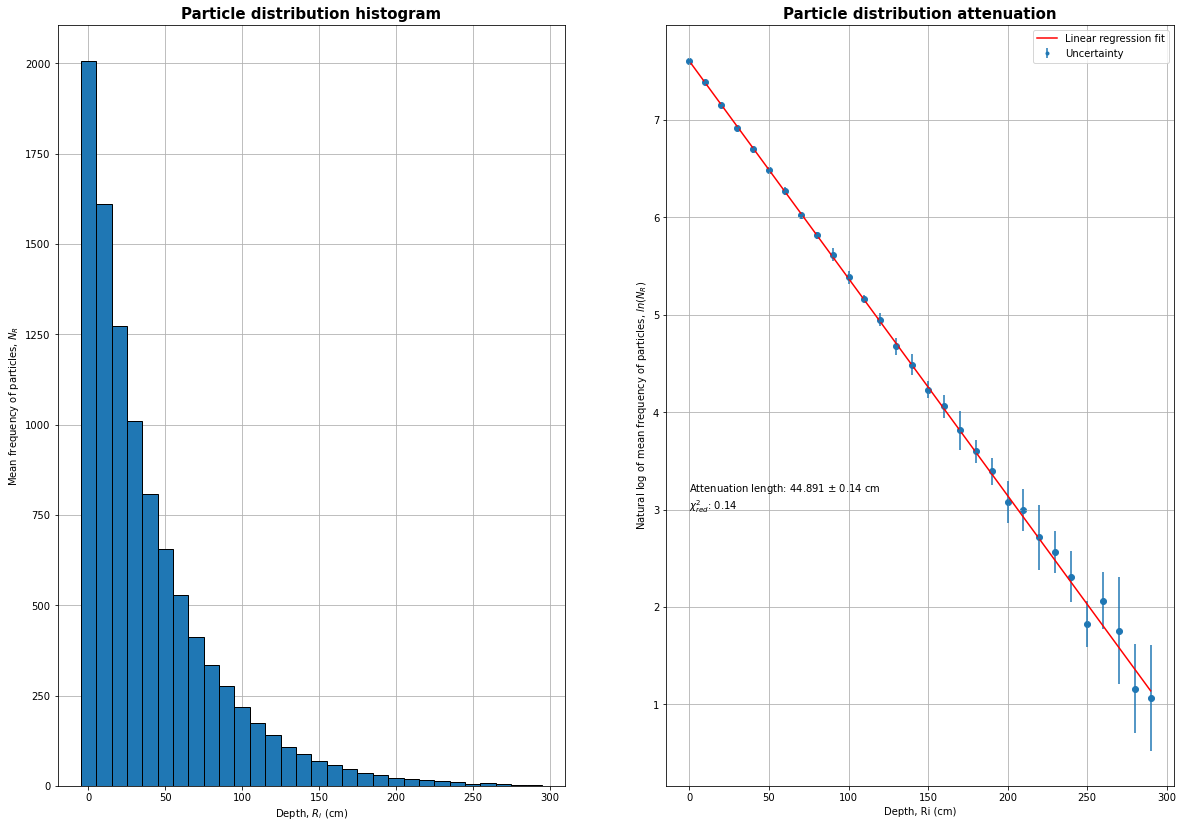

In [5]:
def exponential():
    """
    Plot the particle distribution histogram and the attenuation of neutrons travelling through water.
    As no scattering is taken into account this leads to a mean free path of 45 cm
    
    n_iterations (int): Number of iterations to perform
    n_particles (int): Number of particles to generate
    nbins (int): Number of bins to use for the histogram
    rmax (int): Maximum depth to consider
    lambda_nominal (float): Nominal lambda value for exponential distribution
    
    Args:
        None

    Returns:
        None
    """    
    # Define global variables
    global Ri, NR
    
    # Loop over n_iterations number of iterations to generate particle distribution histogram
    for i in range(n_iterations):
        
        # Generate n_particles random values and calculate the histogram of these values
        NR[i, :], rbins = np.histogram(-lambda_nominal*np.log(np.random.uniform(
            size=n_particles)), bins=nbins, range=(0, rmax))
        
    # Discard the last value of rbins and store the rest in the same variable
    rbins = rbins[:-1]

    # Calculate mean and standard deviation of frequencies
    mean_freq = np.zeros(nbins)
    std_freq = np.zeros(nbins)

    # Loop over nbins number of iterations to generate particle distribution histogram
    for i in range(nbins):
        mean_freq[i] = np.mean(NR[:, i])
        std_freq[i] = np.std(NR[:, i])

    # Remove bins with zero mean or standard deviation
    deleteable_indices = np.where((mean_freq == 0) | (std_freq == 0))
    mean_freq = np.delete(mean_freq, deleteable_indices)
    std_freq = np.delete(std_freq, deleteable_indices)
    rbins = np.delete(rbins, deleteable_indices)

    # Perform linear regression on the logarithm of mean frequency values
    popt, pcov = np.polyfit(rbins, np.log(mean_freq), 1,
                            cov=True, w=(mean_freq/std_freq))

    
    # Calculate the reduced chi-squared value
    reduced_chi_square = np.sum((np.log(mean_freq) - (popt[0]*rbins + popt[1]))**2 / (std_freq/mean_freq)**2)/(nbins-1)

    # Calculate the characteristic attenuation length and its error
    characteristic_attenuation_length = -1/popt[0]
    characteristic_attenuation_length_error = abs(np.sqrt(abs(pcov[0][0]))/popt[0])*characteristic_attenuation_length

    # Create a plot with two subplots
    fig, axs = plt.subplots(1, 2, figsize=(20, 14))
    
    # Plot the histogram of frequencies in the first subplot
    axs[0].bar(rbins, mean_freq, width=np.diff(rbins)[0], edgecolor = 'black', zorder=3)
    axs[0].grid(zorder=0)
    axs[0].set_xlabel('Depth, $R_i$ (cm)')
    axs[0].set_ylabel('Mean frequency of particles, $N_R$')
    axs[0].set_title('Particle distribution histogram',
                     fontsize=15, fontweight='bold')
    
    # Plot the attenuation curve and the linear regression fit in the second subplot
    axs[1].scatter(rbins, np.log(mean_freq))
    axs[1].text(0, 3, 'Attenuation length: {0:.3f} $\pm$ {1:.2f} cm\n$\chi_{{red}}^2$: {2:.2f}'.format(characteristic_attenuation_length, characteristic_attenuation_length_error, reduced_chi_square))
    axs[1].plot(rbins, np.polyval(popt, rbins), c='r', label='Linear regression fit')
    axs[1].errorbar(rbins, np.log(mean_freq), yerr=(std_freq/mean_freq), label='Uncertainty', fmt='.')
    axs[1].grid()
    axs[1].set_xlabel('Depth, Ri (cm)')
    axs[1].set_ylabel(
        'Natural log of mean frequency of particles, $ln(N_R)$')
    axs[1].set_title('Particle distribution attenuation',
                     fontsize=15, fontweight='bold')
    axs[1].legend()
    plt.show()
    
exponential()

As seen above the diagrams show a reliable exponential behaviour of the particle attenuation, showing that the function created is now fit for purpose to be applied to neutron traveling simulation.

In the diagram to the left, the histogram shown is the mean of $10$ iterations. So each bin shown is actually the mean of $10$ different values of particle counts. There are 30 bins in total to take into account an interval of $10$ cm. The total depth taken was $300$ cm.

To the right, the diagram shows the expected behaviour of the neutron attenuating through water. In order to check the accuracy of the values being produced, a line of best fit was used and the fitted attenuation length was found to roughly be $45$ cm with a reduced chi-squared, $\chi_{{red}}^2$, of roughly $0.10$. Although under normal circumstances, a very small $\chi_{{red}}^2$  suggests an over-fitted dataset, because the only contribution to uncertainties of the sampling comes from the PRNG, and given that the mean free path is only an order of magnitude away from the depth, this is acceptable.

## 5. Expanding the exponential behaviour in 3D

The successful implementation of the exponential behaviour can now be expanded to 3D in order to take into account that the world is 3D. This will also help with visualisation of the neutron scattering later on. 

### 5.1 Isotropic and Non Isotropic Unit Vectors    


In order to model the neutron scattering in 3D, the exponential behaviour of the neutron in 2D needs to be vectorised. This is easily done by applying PRNG to the angles involved in spherical polar coordinates which can then be converted into Cartesian coordinates.


$$x=r\sin{\theta}\cos{\phi} \newline
y = r\sin{\theta}\sin{\phi} \newline
z = r\cos{\theta}
$$

with $r=1$ as we are considering unit vectors.

At first thought, it might seem reasonable to simply apply the PRNG between [$0$, $\pi$] for $\theta$ and [$0$ to $2\pi$] for $\phi$, this actually creates a biased distribution of points along the 3D isotropic unit vector at the top and bottom of the sphere of unit vectorised points due to the gradient of the function.



In order to solve this, we modify $\theta$ to accept the PRNG values through

$$\theta = \arccos{(1-2u_i)}.$$

This fixes the bias present as the arccos function with its inverse property negates the cos function bias as can be seen in the comparison below.

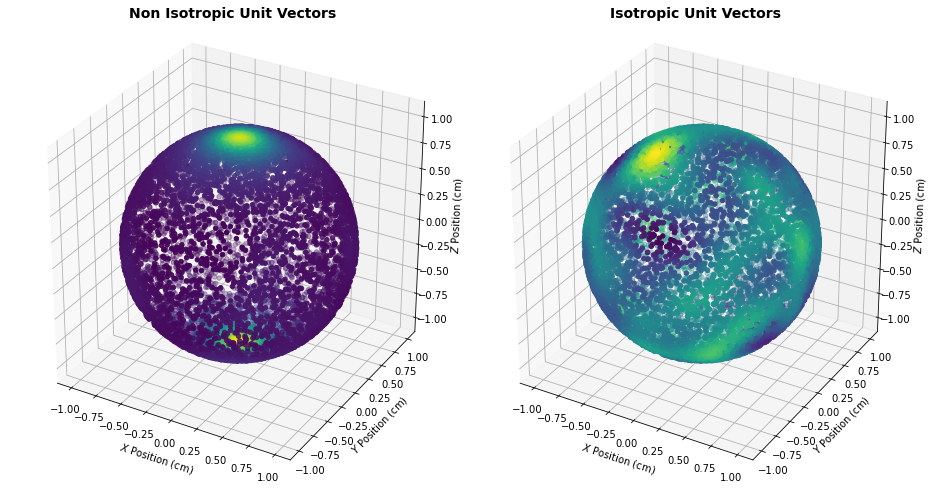

In [6]:
def non_isotropic_unit_vectors(n):
    """
    Generates `n` isotropic unit vectors with random orientations in 3D space.
    
    Args:
    n (int): The number of unit vectors to generate.
        
    Returns:
    x, y, z (numpy.ndarray): Three numpy arrays of shape (n,), representing the x, y, and z components of the generated vectors.
    """
   
    # Generate `n` random angles between 0 and pi (non-uniformly distributed)
    non_uniform_theta = np.random.uniform(0, np.pi, size=n)
    
    # Generate `n` random angles between 0 and 2pi (uniformly distributed)
    uniform_phi = np.random.uniform(0, 2*np.pi, size=n)

    # Convert spherical coordinates to Cartesian coordinates to get x, y, and z components of vectors
    x = np.sin(non_uniform_theta)*np.cos(uniform_phi)
    y = np.sin(non_uniform_theta)*np.sin(uniform_phi)
    z = np.cos(non_uniform_theta)
    
    return x, y, z

def isotropic_unit_vectors(n):
    """
    Generates `n` isotropic unit vectors with random orientations in 3D space.
    
    Args:
    n (int): The number of unit vectors to generate.
        
    Returns:
    x, y, z (numpy.ndarray): Three numpy arrays of shape (n,), representing the x, y, and z components of the generated vectors.
    """
    
    # Generate `n` random angles between 0 and pi (uniformly distributed)
    uniform_theta = np.arccos(1 - 2*(np.random.uniform(0, 1, size=n)))
    
    # Generate `n` random angles between 0 and 2pi (uniformly distributed)
    uniform_phi = np.random.uniform(0, 2*np.pi, size=n)

    # Convert spherical coordinates to Cartesian coordinates to get x, y, and z components of vectors
    x = np.sin(uniform_theta)*np.cos(uniform_phi)
    y = np.sin(uniform_theta)*np.sin(uniform_phi)
    z = np.cos(uniform_theta)
    
    return x, y, z


def colors(x, y, z):
    """
    Assigns a color to each point in 3D space based on the density of points around it.
    
    Args: 
    x, y, z (numpy.ndarray): Three numpy arrays of shape (n,), representing the x, y, and z coordinates of the points.
        
    Returns: 
    colors (numpy.ndarray): A numpy array of shape (n,), representing the assigned color for each point.
    """
    
    # Stacks the randomly generated points in 3D into one array
    points = np.vstack((x, y, z))
    
    # Uses the points to produce a Gaussian kernel density estimator (KDE). 
    # This is a function can be used to estimate the density of points at any location in three-dimensional space.
    density_function = gaussian_kde(points)
    
    # Passes the array of 3D points generated through the Gaussian KDE to match point density with color difference
    colors = density_function(points)

    return colors

# Generate non-isotropic unit vectors and their associated colors
x1, y1, z1 = non_isotropic_unit_vectors(n_particles)
colors1 = colors(x1, y1, z1)


# Generate isotropic unit vectors and their associated colors
x2, y2, z2 = isotropic_unit_vectors(n_particles)
colors2 = colors(x2, y2, z2)

# Create a figure with two subplots for the two sets of points
fig2, axs = plt.subplots(1,2, figsize=(13,10), subplot_kw = {'projection':'3d'})
fig2.tight_layout(h_pad = 5)

# Set the axis labels and aspect ratio for each subplot
for i in range(2):
    [axs[i].set_xlabel('$X$ Position (cm)')]
    [axs[i].set_ylabel('$Y$ Position (cm)')]
    [axs[i].set_zlabel('$Z$ Position (cm)')]
    [axs[i].set_box_aspect((1,1,1))]

# Set the title and scatter plot of the first subplot
axs[0].set_title('Non Isotropic Unit Vectors', fontsize=14, weight='bold')
axs[0].scatter(x1, y1, z1, c=colors1)

# Set the title and scatter plot of the second subplot
axs[1].set_title('Isotropic Unit Vectors', fontsize=14, weight='bold')
axs[1].scatter(x2, y2, z2, c=colors2)

# Show the plot
plt.show()

As before, the colors represent the density of points at the area. The presence of concentrated values at the top and bottom indicates the occurrence of "poles". These points of high concentration are a result of the spherical geometry. When considering a unit area on a sphere, the surface elements near the poles become smaller, leading to a greater concentration of values in those regions.

An isotropic distribution of points should be even as shown in the right diagram. The sphere will not have a perfectly even distribution as the sampling is random, so there will be slight deviations which explains the patches of green and blue.

### 5.2 Isotropic Steps

As we now have an isotropic unit vector, we can model particles randomly taking an isotropic step to see what they look like. The expectation is that they will be concentrated in the center, with a few particles traveling further outwards as we also consider attenuation. 

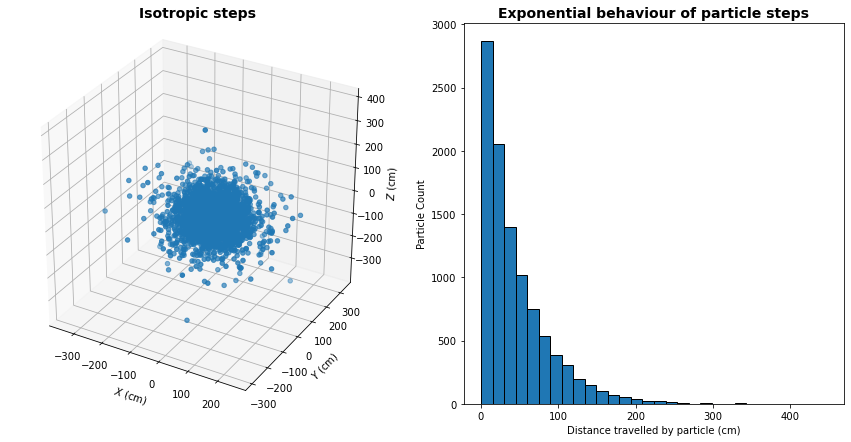

In [7]:
def random_isotropic_step(mean_free_path, n):
    """
    Generates n random isotropic steps for a particle, each with a mean free path of mean_free_path.

    Args:
    mean_free_path (float): The mean distance that a particle will travel before experiencing a collision.
    n (int): The number of steps to generate.

    Returns:
    tuple: A tuple containing three arrays representing the x, y, and z components of the particle's steps.
    """
    
    # Generate n isotropic unit vectors
    x, y, z = isotropic_unit_vectors(n)
    
    # Generate the lengths of each step
    length_of_steps = -mean_free_path*np.log(np.random.uniform(size=n))
    
    # Multiply each unit vector by its respective step length to get the x, y, and z components of the steps
    (steps_x, steps_y, steps_z) = length_of_steps*(x, y, z)

    return (steps_x, steps_y, steps_z)

# Generate n random isotropic steps with a mean free path of lambda_nominal
steps_x, steps_y, steps_z = random_isotropic_step(lambda_nominal, n_particles)

# Calculate the length of each step
length_travelled = np.sqrt(steps_x**2 + steps_y**2 + steps_z**2)

# Plot the steps and the distribution of step lengths
fig = plt.figure(figsize=(15,7))

# 3D scatter plot of steps
ax = fig.add_subplot(1,2,1, projection='3d')
ax.scatter(steps_x, steps_y, steps_z)
ax.set_xlabel('$X$ (cm)')
ax.set_ylabel('$Y$ (cm)')
ax.set_zlabel('$Z$ (cm)')
ax.set_box_aspect((1,1,1))
ax.set_title('Isotropic steps', fontsize=14, weight='bold')

# Histogram of step lengths
ax = fig.add_subplot(1,2,2)
ax.hist(length_travelled, nbins, edgecolor='black')
ax.set_xlabel('Distance travelled by particle (cm)')
ax.set_ylabel('Particle Count')
ax.set_title('Exponential behaviour of particle steps', fontsize=14, weight='bold')

# Show the plot
plt.show()

As expected, the particles were mostly concentrated around the center. In order to better evaluate whether the particles are taking exponential steps, the displacement the particles traveled overall was calculated and plotted as a histogram. It shows an exponential distribution thus, giving strong evidence that the isotropic steps are behaving as they should.

## 6. Studying neutron behaviour in water, lead, and graphite

As we now have all the preliminary functions required to generate neutron scattering, we can now proceed to create a program that simulates the behaviour of neutrons as they travel through water, lead, and graphite under various conditions.

|         |<center>Water</center>|<center>Lead</center>|<center>Graphite</center>|
|:--------|:--|:-------------:|-----:|
|<b>Microscopic Absorption, $\sigma _a$ (barn)</b>|$$0.6652$$|$$0.158$$|$$0.0045$$|
|<b>Microscopic Scattering, $\sigma _s$ (barn)</b>|$$103.0$$|$$11.221$$|$$4.74$$|
|<b>Density, $\rho$ (g/cm^3)</b>|$$1.00$$|$$11.35$$|$$1.67$$|
|<b>Molar Mass, $M$ (g/mol)</b>|$$18.0153$$|$$207.2$$|$$12.011$$||

Firstly, we require the macroscopic absorption cross-section ($\Sigma_a$), macroscopic scattering cross-section ($\Sigma_s$), as 
well as the total mean free path ($\Lambda$) for each material. Using the values above, it is possible to calculate them.

The relationship linking the values above with $\Sigma_a$, $\Sigma_s$, and $\Lambda$ are

$$\Sigma_a = n(\sigma _a),$$

$$\Sigma_s = n(\sigma _s),$$

$$\Sigma_t = \Sigma_a + \Sigma_s,$$

from which we can find
$$\Lambda =\frac{1}{\Sigma_t},$$ 

where $n$ is the molecular number density of the element.

It is given by

$$n = \rho\frac{N_A}{M},$$

where $N_A$ is Avogadro's constant.


Using those calculated values, we can also find the probability of absorption to be

$$P(absorption) = \frac{\Sigma_a}{\Sigma_a+\Sigma_s}.$$

This will be important to model the three possible interactions a neutron can have with the shielding, absoprtion, reflection, and scattering.

In [8]:
# Define function to calculate cross sections and mean free path
def calculate_properties(material):
    """
    Calculate the properties of a material for neutron scattering experiments.

    Args:
        material (str): The name of the material. Valid options are 'Water', 'Lead', or 'Graphite'.

    Returns:
        dict: A dictionary containing the properties of the material, including macroscopic absorption,
            macroscopic scattering, total macroscopic cross section, and total mean free path.

        macroscopic_absorption (float): The macroscopic absorption cross section for the material.

        macroscopic_scattering (float): The macroscopic scattering cross section for the material.

        total_mean_free_path (float): The total mean free path for the material.

        absorption_prob (float): The probability that a neutron will be absorbed by the material.
    """
    # Define material properties based on input
    if material == 'Water':
        microscopic_absorption = 0.6652e-24   # microscopic absorption cross section [barns]
        microscopic_scattering = 103.0e-24    # microscopic scattering cross section [barns]
        density = 1.00                        # density [g/cm^3]
        molar_mass = 18.0153                  # molar mass [g/mol]
    elif material == 'Lead':
        microscopic_absorption = 0.158e-24    # microscopic absorption cross section [barns]
        microscopic_scattering = 11.221e-24   # microscopic scattering cross section [barns]
        density = 11.35                       # density [g/cm^3]
        molar_mass = 207.2                    # molar mass [g/mol]
    elif material == 'Graphite':
        microscopic_absorption = 0.0045e-24   # microscopic absorption cross section [barns]
        microscopic_scattering = 4.74e-24     # microscopic scattering cross section [barns]
        density = 1.67                        # density [g/cm^3]
        molar_mass = 12.011                   # molar mass [g/mol]
    else:
        raise ValueError('Please only select Water, Lead, or Graphite')

    # Calculate number of molecules per volume of material
    molecule_number_density = (density * Avogadro) / molar_mass  # number of molecules per volume [cm^-3]
    
    # Calculate total microscopic and macroscopic cross sections
    total_microscopic_X_section = microscopic_absorption + microscopic_scattering    # total microscopic cross section [barns]
    total_macroscopic_X_section = molecule_number_density*total_microscopic_X_section
    total_mean_free_path = 1 / (total_macroscopic_X_section) # total mean free path [cm]

    # Calculate macroscopic absorption and scattering cross sections
    macroscopic_absorption = molecule_number_density*microscopic_absorption
    macroscopic_scattering = molecule_number_density*microscopic_scattering
    

    # Calculate the absorption probability based on macroscopic cross-sections
    absorption_prob = macroscopic_absorption / (macroscopic_absorption + macroscopic_scattering)
    
    # Return results as dictionary and floats
    return {'Material': material,
            'Macroscopic Absorption, $\Sigma_a$ (1/cm)': macroscopic_absorption,
            'Macroscopic Scattering, $\Sigma_s$ (1/cm)': macroscopic_scattering,
            'Total Macroscopic Cross Section, $\Sigma_t$ (1/cm)': total_macroscopic_X_section,
            'Total Mean Free Path, $\Lambda$ (cm)': total_mean_free_path}, macroscopic_absorption, macroscopic_scattering, total_mean_free_path, absorption_prob 

# Calculate properties for each material and store the results and individual properties in variables
water_properties, water_macroscopic_absorption,  water_macroscopic_scattering, water_total_mean_free_path, water_absorption_prob = calculate_properties('Water')
lead_properties, lead_macroscopic_absorption,  lead_macroscopic_scattering, lead_total_mean_free_path, lead_absorption_prob = calculate_properties('Lead')
graphite_properties, graphite_macroscopic_absorption,  graphite_macroscopic_scattering, graphite_total_mean_free_path, graphite_absorption_prob = calculate_properties('Graphite')


# Create a DataFrame from the calculated properties of each material
df = pd.DataFrame([water_properties, lead_properties, graphite_properties], index=["", "" ,""])

# Set the 'Material' column as the index of the DataFrame
df.set_index('Material', inplace=True)

# Format the DataFrame and set the table style
df=df.style.format('{:.3f}').set_table_styles([dict(props=[('font-size', '12pt'), ('font-family', 'Baskerville')])])

# Display the DataFrame as a table
display(df)

,"Macroscopic Absorption, $\Sigma_a$ (1/cm)","Macroscopic Scattering, $\Sigma_s$ (1/cm)","Total Macroscopic Cross Section, $\Sigma_t$ (1/cm)","Total Mean Free Path, $\Lambda$ (cm)"
Material,,,,
Water,0.022,3.443,3.465,0.289
Lead,0.005,0.370,0.375,2.664
Graphite,0.000,0.397,0.397,2.517


The calculated values have been put into a table to track what values we are getting. They show that water has the shortest $\Lambda$. This can be significant because it shows that neutrons will very likely only move a short distance before being completely attenuated and absorbed or reflected.

Lead and graphite show a closer value of $\Lambda$ which suggests that neutrons might behave similarly in the two.

### 6.1 Random walk in water visualised

As we now have the values required to calculate whether a neutron has been absorbed, scattered, or transmitted, we will proceed to simulate the behaviour of the neutron scattering by attempting a random walk of a few neutrons through a water. This is an application of a variant of the MC known as a Markov Chain Monte Carlo (MCMC). This is because the value of the next generated point depends on the previously generated point. 

By confirming its validity, we can then apply this to a more specific scenario for each shielding later on.

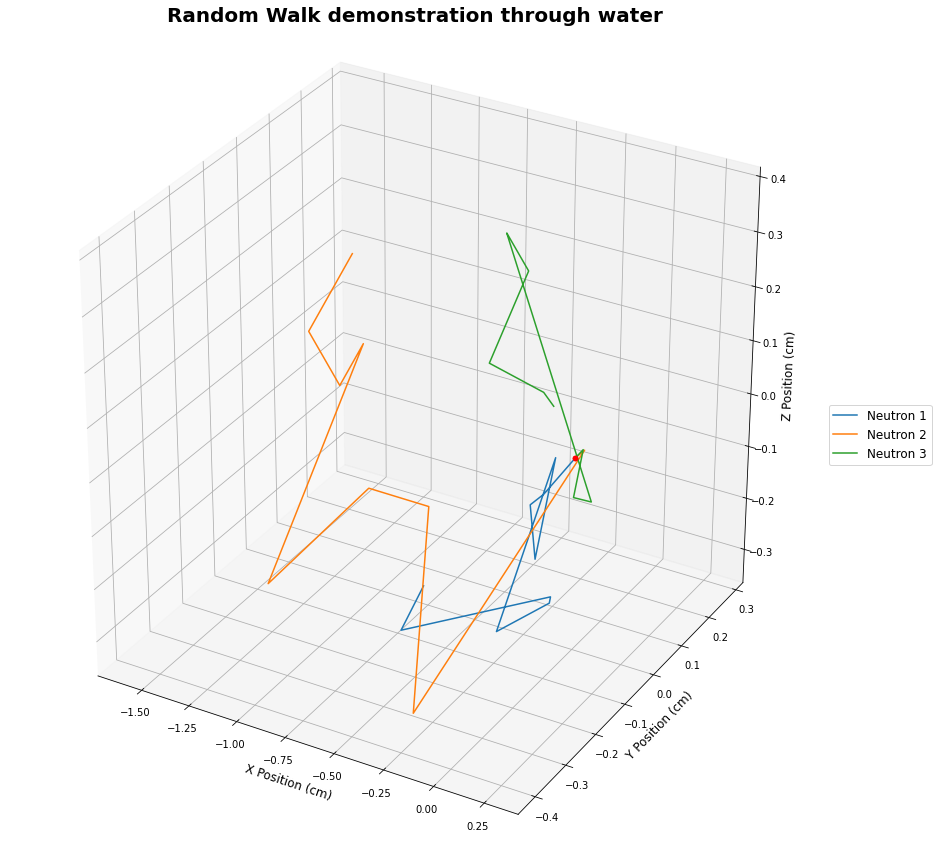

In [9]:
def random_walk_generator(n_iterations, mean_free_path):
    """
    Generates a random walk in three dimensions using a Monte Carlo simulation.

    Args:
    - n_iterations (int): the number of iterations to simulate the random walk
    - mean_free_path (float): the mean free path of the particle being simulated

    Returns:
    - xsteps (numpy array): the x-coordinates of the particle at each iteration
    - ysteps (numpy array): the y-coordinates of the particle at each iteration
    - zsteps (numpy array): the z-coordinates of the particle at each iteration
    """
    # Initialize arrays to store the x, y, and z coordinates of the particle at each iteration
    xsteps = np.zeros(n_iterations)
    ysteps = np.zeros(n_iterations)
    zsteps = np.zeros(n_iterations)

    # Set the starting position of the particle to (0,0,0)
    xsteps[0] = 0
    ysteps[0] = 0
    zsteps[0] = 0

    # Iterate over the number of iterations specified, generating a new isotropic step at each iteration
    for i in range(n_iterations - 1):

        # Generate a new isotropic step with the specified mean free path
        xsteps_temp, ysteps_temp, zsteps_temp = random_isotropic_step(mean_free_path, 1)

        # Update the x, y, and z coordinates of the particle based on the new step
        xsteps[i + 1] = xsteps_temp + xsteps[i]
        ysteps[i + 1] = ysteps_temp + ysteps[i]
        zsteps[i + 1] = zsteps_temp + zsteps[i]

    # Return the x, y, and z coordinates of the particle at each iteration
    return xsteps, ysteps, zsteps


def random_walk_plotter(mean_free_path):
    """
    Plots the random walk of a specified number of particles in three dimensions.
    """

    # Initialize arrays to store the x, y, and z coordinates of each particle
    xsteps = [0] * number_of_walking_particles
    ysteps = [0] * number_of_walking_particles
    zsteps = [0] * number_of_walking_particles

    # Generate a random walk for each particle
    for i in range(number_of_walking_particles):
        xsteps[i], ysteps[i], zsteps[i] = random_walk_generator(n_iterations, mean_free_path)

    # Create a new figure with a 3D projection
    fig = plt.figure(figsize=(15, 15))
    ax = plt.axes(projection='3d')

    # Plot the random walk of each particle
    for i in range(number_of_walking_particles):
        label = "Neutron " + str(i + 1)
        ax.plot(xsteps[i], ysteps[i], zsteps[i], label=label)

        # Highlight the starting position of each particle in red
        ax.scatter(xsteps[i][0], ysteps[i][0], zsteps[i][0], color='red')

    # Set the axis labels and aspect ratio
    ax.set_xlabel('X Position (cm)', fontsize=12)
    ax.set_ylabel('Y Position (cm)', fontsize=12)
    ax.set_zlabel('Z Position (cm)', fontsize=12)
    ax.set_box_aspect((1, 1, 1))

    # Add a legend to the plot
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize=12)

    # Set the title of the plot
    ax.set_title('Random Walk demonstration through water', fontsize=20, fontweight='bold')

    # Show the plot
    plt.show()


# Generate and plot a random walk for water
random_walk_plotter(water_total_mean_free_path)

As seen above, even when all the particles start at the same position marked by red, they proceed to walk away from each other with no correlation to each other, showing that the neutrons are properly walking in random directions. This means the looping functionality to utilise the isotropic steps is correct. 

This random walk is for if the neutrons start scattering inside water. For lead and graphite, the procedure will be the same, but the scaling will be different since they have a bigger total mean free path. This will be more noticeable below where a few neutrons have been simulated interacting with each material from outside to inside the shielding.

### 6.2 Applying random walk for neutron scattering through shielding

We will now proceed to apply what we have learned in section 6.1 to take into account $L$, differing materials as well as the fact that neutrons don't suddenly scatter inside the shielding, but are given the kinetic energy to do so from outside the material. 

We will look at the case for when each shielding has $L = 10$ cm which is matched to the x-axis. The initial position of the neutrons have been color coded red just like section 6.1, while the slab start and end planes have been visualised using orange meshgrids. 

The neutrons will enter the materials from the left and some space has been provided to distinguish between the start of the slab and the end of the slab. 

We assume that the slabs have an infinite thickness along the z-axis and y-axis to see the scattering properly, since only the x-axis determines whether the neutrons transmit, reflect, or are absorbed.

In [10]:
slab_end = 10  # Sets where the end of the slab is along the x-coordinate (cm)
slab_start = 0 # Sets where the start of the slab is along the x-coordinate (cm)
npoints = 100  # Sets number of points to be generated along the y and z axes for the 3-D plot of the random walk simulation (cm)

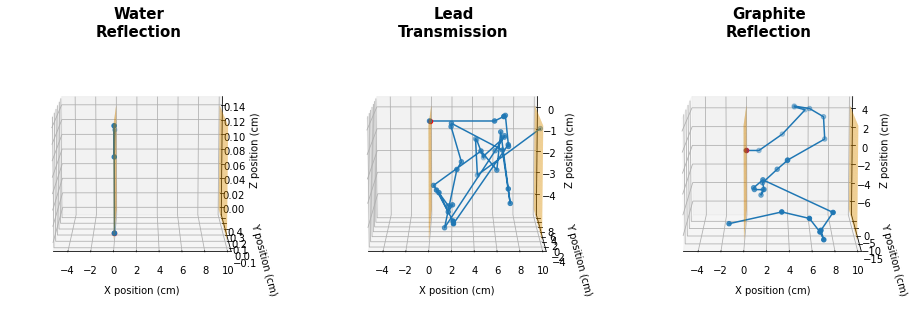

In [11]:
def position_storage(n_particles, total_mean_free_path, thickness, absorption_prob):
    """
    Simulates the movement of particles in a slab of material with given properties and records their positions.
    
    Args:
        n_particles (int): The number of particles to simulate.
        total_mean_free_path (float): The average distance traveled by a particle before undergoing an interaction.
        thickness (float): The thickness of the slab.
        absorption_prob (float): The probability of a particle being absorbed in one interaction.
    
    Returns:
        x_array (np.array): The x-coordinates of the particle positions.
        y_array (np.array): The y-coordinates of the particle positions.
        z_array (np.array): The z-coordinates of the particle positions.
        label (str): The label of the final interaction undergone by the particle.
    """
    # Initialize the arrays to store the particle positions and the final interaction label
    x_array = np.array([[0], [-total_mean_free_path * np.log(np.random.uniform(size=n_particles))]], dtype=object)
    y_array = np.zeros(n_particles + 1)
    z_array = np.zeros(n_particles + 1)
    
    
    label = 'Absorption'
    active = True
    
    # Loop until the particle is absorbed or has exited the slab
    while np.random.uniform() > absorption_prob and active:
        
        # Generate a random step for the particle
        step_x, step_y, step_z = random_isotropic_step(total_mean_free_path, 1)
        
        # Update the particle position arrays
        x_array = np.append(x_array, x_array[-1] + step_x)
        y_array = np.append(y_array, y_array[-1] + step_y)
        z_array = np.append(z_array, z_array[-1] + step_z)
        
        # Check if the particle has exited the slab
        if x_array[-1] > thickness:
            label, active = 'Transmission', False
        elif x_array[-1] < 0:
            label, active = 'Reflection', False
    return x_array, y_array, z_array, label


# Simulate the particle positions for each material
water_pos = position_storage(1, water_total_mean_free_path, slab_end, water_absorption_prob)
lead_pos = position_storage(1, lead_total_mean_free_path, slab_end, lead_absorption_prob)
graphite_pos = position_storage(1, graphite_total_mean_free_path, slab_end, graphite_absorption_prob)

# Set up the meshgrid for plotting the particle positions
water_zz, water_yy = np.meshgrid(np.linspace(water_pos[2].min(), water_pos[2].max(), npoints), np.linspace(water_pos[1].min(), water_pos[1].max(), npoints))
lead_zz, lead_yy = np.meshgrid(np.linspace(lead_pos[2].min(), lead_pos[2].max(), npoints), np.linspace(lead_pos[1].min(), lead_pos[1].max(), npoints))
graphite_zz, graphite_yy = np.meshgrid(np.linspace(graphite_pos[2].min(), graphite_pos[2].max(), npoints), np.linspace(graphite_pos[1].min(), graphite_pos[1].max(), npoints))


# Plot the particle paths and the slab boundaries for each material
fig, axes = plt.subplots(1, 3, figsize=(16, 12), subplot_kw={'projection': '3d'})
for i, (pos, zz, yy, title) in enumerate(zip([water_pos, lead_pos, graphite_pos], [water_zz, lead_zz, graphite_zz], [water_yy, lead_yy, graphite_yy], ['Water\n', 'Lead\n', 'Graphite\n'])):
    axes[i].set_title(title + pos[3], fontsize=15, fontweight='bold')
    axes[i].set_xlabel('X position (cm)', labelpad=10)
    axes[i].set_ylabel('Y position (cm)', labelpad=10)
    axes[i].set_zlabel('Z position (cm)', labelpad=10)
    axes[i].set_xlim([-5, slab_thickness])
    axes[i].plot(pos[0], pos[1], pos[2])
    axes[i].scatter(pos[0][0], pos[1][0], pos[2][0], color='red')  # Color the starting position red
    axes[i].scatter(pos[0], pos[1], pos[2])
    axes[i].plot_surface(slab_end, yy, zz, alpha=0.5, color='orange')
    axes[i].plot_surface(slab_start, yy, zz, alpha=0.5, color='orange')
    axes[i].view_init(elev=10, azim=-90)

# Display the figure
plt.show()

As shown above, the behaviour of the neutrons show a successful application of the random walks with the absorption probability and total mean free path taken into account for each material. 

Water shows the least amount of movement along the x-axis which is expected, since the total mean free path is small. As illustrated in section 6.1, where if we observe the scale of the axes, we notice that they are an order of magnitude smaller than the scaling of the slabs visualised for section 6.2. 

Section 6.2 can be rerun multiple times and a difference in the outcome will be noticed for transmission, reflection, and absorption for each material. However, the rate of one outcome over the others is not clear unless we iterate the process to a statistically significant amount of $10,000$ neutrons over $10$ iterations. 

### 6.3 Simulating the rates of transmission, absorption, and reflection

As it is inefficient to study the rates of transmission, absorption, and reflection by visualising the behaviour in 3D, we will reduce the number of dimensions considered to 1D; this is helpful in several ways. 

Firstly, as only the x-axis matters, we reduce redundancy of the code especially if no visualisation is needed.

Secondly, the computational power needed for 3D visualisation is immense, since the history of the particle at each point needs to be stored via np.append. By replacing them with numpy arrays and indexing techniques, we can improve the runtime by at least 10x times.

Thirdly, by only considering one dimension, extra optimisation can be implemented such as with the use of the PRNG on the x-axis position. As it is merely a matter of convention on whether x is defined as 

 $$ x=\sin{\theta}\cos{\phi}, $$
 
we redefine it here as 

$$x = \cos{\theta}$$

replacing $z$ with $x$.

Further simplifying the code, we replace $\cos{\theta}$ with $u_i [-1, 1]$ as they are mathematically equivalent. This cuts the runtime of the code by 10 seconds as we only need to apply PRNG once instead of twice to get a value of $x$.

Having cut the runtime, we can now discuss the theory of the interaction of the neutrons. The will be attenuated in a similar manner to the model we made in section 4. 

We take the decay equation:

\begin{equation}
N(x) = N_0 \cdot e^{-\frac{x}{\lambda}}
\end{equation}

where $N(x)$ is the number of particles present and $N_0$ is the initial number of particles. We set $N_0 = 1$ as we will represent the length of steps $10,000$ particles took instead of the number of particles left after $10,000$ steps.  

In [12]:
def compute_RAT(n_particles, n_iterations, material, L):
    """
    Compute the reflected, absorbed, and transmitted rates for a given material and thickness.

    Args:
    n_particles (int): The number of particles used to compute the rates.
    n_iterations (int): The number of iterations used to compute the rates.
    material (str): The material of interest. It should be one of: "Water", "Lead", "Graphite".
    L (float): The thickness of the material.

    Returns:
    mean_reflected_rate (float): The mean reflected rate.
    errors_reflected_rate (float): The standard error of the mean of the reflected rate.
    mean_absorbed_rate (float): The mean absorbed rate.
    errors_absorbed_rate (float): The standard error of the mean of the absorbed rate.
    mean_transmitted_rate (float): The mean transmitted rate.
    errors_transmitted_rate (float): The standard error of the mean of the transmitted rate.
    """
    # initialize arrays to store number of particles reflected, absorbed, and transmitted
    n_reflected = np.zeros(n_iterations)
    n_transmitted = np.zeros(n_iterations)
    n_absorbed = np.zeros(n_iterations)
    
    # calculate macroscopic properties of the material
    _, macro_absorption, macro_scattering, total_mean_free_path, absorption_prob = calculate_properties(material)

    # run the simulation for the given number of iterations
    for iter in range(n_iterations):
        
        # initialize position of the particles randomly within the material
        x=-total_mean_free_path*np.log(np.random.uniform(size=n_particles))

        # continue simulation while there are still particles within the material
        while(x.size>0):
            
            # generate random numbers for each particle to determine if it is reflected, absorbed, or transmitted
            u=np.random.uniform(size=len(x))
            n_reflected[iter]+=np.count_nonzero(x<0)
            n_transmitted[iter]+=np.count_nonzero(x>L)
            n_absorbed[iter]+=np.count_nonzero(u[np.argwhere((x>0)&(x<L))]<absorption_prob)
            
            # remove particles that have left the material or have been absorbed
            x=np.delete(x,np.argwhere((x<0)|(x>L)|(u<absorption_prob)))
             
            # update the positions of the remaining particles
            x+=-total_mean_free_path*np.log(np.random.uniform(size=x.size))*np.random.uniform(-1,1,x.size)

    # calculate mean and standard error of the mean for the number of particles reflected, absorbed, and transmitted
    mean_reflected_rate = np.mean(n_reflected)/n_particles
    mean_absorbed_rate = np.mean(n_absorbed)/n_particles
    mean_transmitted_rate = np.mean(n_transmitted)/n_particles
    errors_reflected_rate = np.std(n_reflected)/n_particles
    errors_absorbed_rate = np.std(n_absorbed)/n_particles
    errors_transmitted_rate = np.std(n_transmitted)/n_particles

    # return the computed values
    return mean_reflected_rate, errors_reflected_rate, mean_absorbed_rate,  errors_absorbed_rate, mean_transmitted_rate, errors_transmitted_rate

# initialize arrays to store values for each material and thickness
water_array = np.zeros((exponential_thickness.size, 6))
lead_array = np.zeros((exponential_thickness.size, 6))
graphite_array = np.zeros((exponential_thickness.size, 6))    

# loop over each thickness and calculate the RAT values for each material
for iL in tnrange(0, exponential_thickness.size, desc="Progress"):
    L=exponential_thickness[iL]
    water_array[iL] = compute_RAT(n_particles, n_iterations, "Water", L)
    lead_array[iL] = compute_RAT(n_particles, n_iterations, "Lead", L)
    graphite_array[iL] = compute_RAT(n_particles, n_iterations, "Graphite", L)

# Transpose the arrays so that each row contains the values for a material (reflected, absorbed, transmitted) 
# while each column contains the values for a thickness
water_values = np.transpose(water_array) 
lead_values = np.transpose(lead_array)
graphite_values = np.transpose(graphite_array)

A progress bar has been added to show how long it takes to run the code for $10,000$ neutrons in $10$ iterations for $20$ cm. It shows that the entire process takes under 20 seconds which is efficient 

Using the code, we proceed to find the mean rates of neutron scattering when $L = 10$ cm to get discrete values to contextualise the data as a table

In [13]:
def fixed_thickness_RAT(material):
    """Calculate the Reflection, Absorption, and Transmission rates of a material at a fixed thickness.
    
    Args:
    material (str): The material to calculate the RAT values of (e.g. "Water", "Lead", "Graphite").
    
    Returns:
    results_df (pandas DataFrame): A pandas DataFrame containing the RAT values and uncertainties for the given material.
    """
    # Define material properties
    if material == 'Water':
        material_at_set_thickness = compute_RAT(n_particles, n_iterations, "Water", slab_thickness)
    
    elif material == 'Lead':
        material_at_set_thickness = compute_RAT(n_particles, n_iterations, "Lead", slab_thickness)

    elif material == 'Graphite':
        material_at_set_thickness = compute_RAT(n_particles, n_iterations, "Graphite", slab_thickness)


    # Create pandas DataFrame with results
    results_df = pd.DataFrame({'Material': material,
                               'Transmission rate ($\%$)': material_at_set_thickness[4]*100,
                               'Reflection rate ($\%$)': material_at_set_thickness[0]*100,
                               'Absorption rate ($\%$)': material_at_set_thickness[2]*100,
                               'Transmission rate uncertainty ($\%$)': material_at_set_thickness[5]*100,
                               'Reflection rate uncertainty ($\%$)': material_at_set_thickness[1]*100,
                               'Absorption rate uncertainty ($\%$)': material_at_set_thickness[3]*100},
                              index=[0])

    return results_df

# Concatenate RAT values of different materials into a single DataFrame
results_df = pd.concat([fixed_thickness_RAT(material) for material in materials])

# Set the material name as the index of the DataFrame
results_df.set_index('Material', inplace=True)

# Format the RAT values to one decimal place and style the DataFrame
results_df = results_df.style.format('{:.1f}').set_table_styles([dict(props=[('font-size', '12pt'), ('font-family', 'Baskerville')])])

# Display the DataFrame
display(results_df)

,Transmission rate ($\%$),Reflection rate ($\%$),Absorption rate ($\%$),Transmission rate uncertainty ($\%$),Reflection rate uncertainty ($\%$),Absorption rate uncertainty ($\%$)
Material,,,,,,
Water,0.3,79.7,20.0,0.1,0.4,0.4
Lead,28.1,61.8,10.1,0.6,0.6,0.3
Graphite,30.6,68.6,0.8,0.6,0.5,0.1


<b>Water:</b>

Water has an incredibly low transmission rate in comparison to its reflection absorption rate as shown by the percentages. The fact that the associated uncertainty is also small gives confidence to the idea that water would be a good shield to stop neutrons. The fact that it reflects the majority of the neutrons means that the reaction chain will be long lasting provided that the water is the only source of attenuation.

<b>Lead and graphite:</b>

Lead and graphite both show a similar value for transmission and reflection, but a significant difference in absorption. Their transmission is roughly around $30 \%$ which is considerably high compared to water. This suggests that water will be a better choice as a shield if the goal is to purely stop neutrons. A difference between lead and graphite is seen where lead has a much higher absorption rate. This is likely due to the fact that lead has a higher density than graphite.

Having found the mean rates at $L=10$ cm, we can proceed to plot them for $L=[1,20]$ cm for each type of interaction to see how they vary with $L$. 

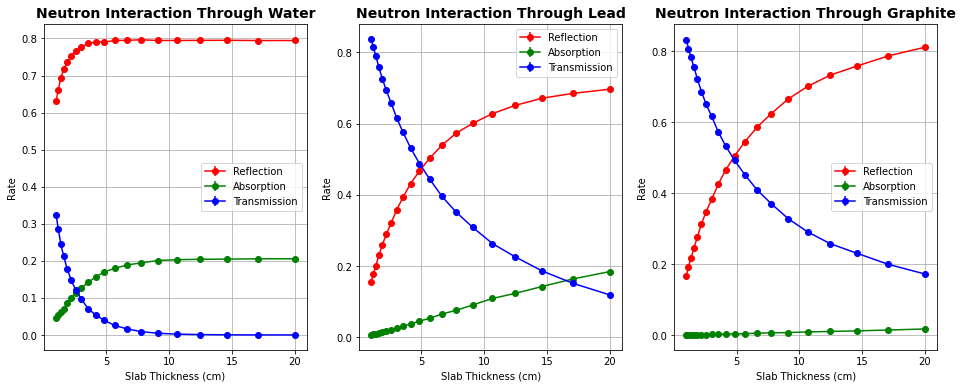

In [14]:
material_values = [water_values, lead_values, graphite_values]

# Create a figure with three subplots
fig3, ax = plt.subplots(1,3, figsize=(16,6))

# Set titles for each subplot
ax[0].set_title('Neutron Interaction Through Water', fontsize=14, fontweight='bold')
ax[1].set_title('Neutron Interaction Through Lead', fontsize=14, fontweight='bold')
ax[2].set_title('Neutron Interaction Through Graphite', fontsize=14, fontweight='bold')

# Plot the data for each material on its respective subplot
for i in range(3):
    
    # Plot the reflection data with error bars
    ax[i].errorbar(exponential_thickness, material_values[i][0], yerr=material_values[i][1], fmt='o-', c = 'red', label='Reflection')
    
    # Plot the absorption data with error bars
    ax[i].errorbar(exponential_thickness, material_values[i][2], yerr=material_values[i][3], fmt='o-', c = 'green', label='Absorption')
    
    # Plot the transmission data with error bars
    ax[i].errorbar(exponential_thickness, material_values[i][4], yerr=material_values[i][5], fmt='o-', c = 'blue', label='Transmission')
    
    # Add axis labels, legends, and gridlines to each subplot
    ax[i].set_xlabel('Slab Thickness (cm)')
    ax[i].set_ylabel('Rate')
    ax[i].legend()
    ax[i].grid()

# Display the figure
plt.show()

An interesting observation here is that depending on the range of $L$, the ratio of reflection, transmission, and absorption changes. Water shows a switch between absorption and transmission rates at a range lower than $5$ cm while lead and graphite shows reflection and transmission switching over at around $5$ cm. 

We can infer from this that thicknesses influence reflection such that at higher thicknesses, reflection rates will increase likely due to the greater opportunity it gives the neutrons to be scattered back by the atoms it hits. This is the same with absorption but to a lesser extent because absorption requires precise angles for the neutrons to hit the materials.

With transmission, we can naturally infer a decrease in rates because the thicker the material, the greater the reflection and absorption rates become.

,Attenuation Length (cm),Attenuation Length Error (cm),Reduced Chi-Squared
Material,,,
Water,1.83,0.04,3.05
Lead,8.47,0.21,19.70
Graphite,9.53,0.37,46.11


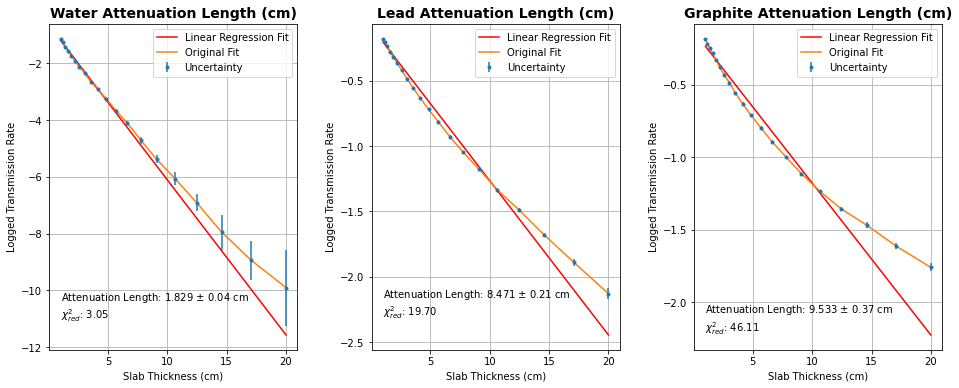

In [15]:
def attenuation_length(x, mean_transmission_rates, mean_transmission_errors):
    """
    Function to calculate the characteristic attenuation length and its uncertainty using a linear regression fit.
    Parameters:
    -----------
    x: numpy.ndarray
        Array of the thickness of the material in cm.
    mean_transmission_rates: numpy.ndarray
        Array of the mean transmission rates of the beam through the material.
    mean_transmission_errors: numpy.ndarray
        Array of the mean transmission errors of the beam through the material.
    Returns:
    --------
    x: numpy.ndarray
        Array of the thickness of the material in cm after removing the invalid indices.
    ylog: numpy.ndarray
        Array of the logged mean transmission rates after removing the invalid indices.
    mean_transmission_errors: numpy.ndarray
        Array of the mean transmission errors after removing the invalid indices.
    characteristic_attenuation_length: float
        Characteristic attenuation length calculated using the linear regression fit.
    characteristic_attenuation_length_error: float
        Uncertainty in the characteristic attenuation length calculated using the linear regression fit.
    popt: numpy.ndarray
        Array of coefficients of the linear regression fit.
    reduced_chi_square: float
        Reduced chi-square value of the fit.
    """
    # Remove invalid indices where mean_transmission_rates and mean_transmission_errors are 0
    valid_index = np.where((mean_transmission_rates != 0) & (mean_transmission_errors != 0))
    x, mean_transmission_rates, mean_transmission_errors = x[valid_index], mean_transmission_rates[valid_index], mean_transmission_errors[valid_index]
    
    # Calculate the weights, logarithm, and linear regression fit
    weights = mean_transmission_rates / mean_transmission_errors
    ylog = np.log(mean_transmission_rates)
    popt, pcov = np.polyfit(x, ylog, 1, w=weights, cov=True)
    
    # Calculate characteristic attenuation length and its uncertainty
    characteristic_attenuation_length = -1 / popt[0]
    characteristic_attenuation_length_error = abs(np.sqrt(abs(pcov[0][0])) / popt[0]) * characteristic_attenuation_length
    
    # Calculate the mean transmission errors for the reduced chi-square calculation
    mean_transmission_errors = 1 / weights
    
    # Calculate the reduced chi-square of the fit
    reduced_chi_square = np.sum((ylog - (popt[0] * x + popt[1])) ** 2 / mean_transmission_errors ** 2) / (nbins - 1)
    
    return x, ylog, mean_transmission_errors, characteristic_attenuation_length, characteristic_attenuation_length_error, popt, reduced_chi_square

# Perform the linear regression fit for water, lead, and graphite
# Stores 
water_results = attenuation_length(exponential_thickness, water_values[4], water_values[5])
lead_results = attenuation_length(exponential_thickness, lead_values[4], lead_values[5])
graphite_results = attenuation_length(exponential_thickness, graphite_values[4], graphite_values[5])

# Create a dictionary with the data
data = {
    'Material': ['Water', 'Lead', 'Graphite'],
    'Attenuation Length (cm)': [water_results[3], lead_results[3], graphite_results[3]],
    'Attenuation Length Error (cm)': [water_results[4], lead_results[4], graphite_results[4]],
    'Reduced Chi-Squared': [water_results[6], lead_results[6], graphite_results[6]]
}

# Create a DataFrame from the dictionary
results_df = pd.DataFrame(data)

# Set the material name as the index of the DataFrame
results_df.set_index('Material', inplace=True)

# Format the RAT values to one decimal place and style the DataFrame
results_df = results_df.style.format('{0:.2f}').set_table_styles([dict(props=[('font-size', '17pt'), ('font-family', 'Baskerville')])])

# Display the DataFrame
display(results_df)

# Create a figure with subplots
fig, ax = plt.subplots(1, 3, figsize=(16, 6))

# Adjust the spacing between subplots
fig.subplots_adjust(wspace=0.3)

# Adds text providing information about attenuation length and reduced chi squared values
ax[0].text(1, -11, 'Attenuation Length: {0:.3f} $\pm$ {1:.2f} cm\n$\chi_{{red}}^2$: {2:.2f}'.format(water_results[3], water_results[4], water_results[6]))
ax[1].text(1, -2.3, 'Attenuation Length: {0:.3f} $\pm$ {1:.2f} cm\n$\chi_{{red}}^2$: {2:.2f}'.format(lead_results[3], lead_results[4], lead_results[6]))
ax[2].text(1, -2.2, 'Attenuation Length: {0:.3f} $\pm$ {1:.2f} cm\n$\chi_{{red}}^2$: {2:.2f}'.format(graphite_results[3], graphite_results[4], graphite_results[6]))

# Iterate over the materials and results simultaneously. 
# This loop sets the title, plots the linear regression fit, the uncertainty, the original fit and formats the plot
results = [water_results, lead_results, graphite_results]
for i, (material, result) in enumerate(zip(materials, results)):
    ax[i].set_title(f'{material} Attenuation Length (cm)', fontsize=14, fontweight='bold')
    ax[i].plot(result[0], np.polyval(result[5], result[0]), c='r', label='Linear Regression Fit')
    ax[i].errorbar(result[0], result[1], yerr=result[2], label='Uncertainty', fmt='.')
    ax[i].plot(result[0], result[1], label="Original Fit")
    ax[i].set_xlabel('Slab Thickness (cm)')
    ax[i].set_ylabel('Logged Transmission Rate')
    ax[i].legend()
    ax[i].grid()

# Display the plots
plt.show()

A final study on the materials can be seen above with the shortest attenuation length belonging to water. This means that it is the best shield for stopping neutrons as it requires the least thickness to stop transmission. However, some problems that may not have been considered is that water is a liquid that can corrode materials around it, requiring regular maintenance to ensure that the structure keeping the shielding in place has structural integrity.

Another factor that needs to be considered on deciding the best shielding is whether or not the shield is there to completely stop the neutrons or slow it down for reactions to take place. To that end, graphite and lead are a better choice. They are also better than water at blocking radiation produced by the neutron interactions since they are denser than water.

The $\chi_{{red}}^2$ for lead and graphite are incredibly big. However, this is expected since  for the range of $L$ (up to $20$ cm) and neutron counts of $10000$ considered in this project, the transmission data points tend to deviate from a linear fit at large thicknesses, leading to a large $\chi_{{red}}^2$.

## 7. Woodcock Method

To make the simulation more applicable to real life, another improvement that could be made is the addition of the Woodcock method [4]. The Woodcock method, otherwise known as the fictitious method, is an efficient method of simulating particles traveling through a boundary between two different materials. Suppose there are two materials with different cross-sections, $\Sigma_A$ and $\Sigma_B$, a majorant cross-section is found which is the otherwise known as the maximum of the two cross-sections. When the particle enters the first material there is a probability that it may take a virtual step which is otherwise known as a fictitious step if not by an isotropic step. This is shown as

$$P(fictitious)=1 - \frac{\Sigma_i}{\Sigma_{max}}$$

They don't randomly step in a different direction, nor do they get absorbed or reflected. They merely get checked by a code that monitors every step to see if the step taken was isotropic or fictitious which determines if the particle will then have an absorption or reflection test applied.

## 8.Total Runtime

In order to measure the efficiency of the MC method implemented, the entire code has been timed and the result has been printed below.

In [16]:
end_time = time.time()  # Get the end time of the code
runtime = end_time - start_time  # Calculate the total runtime
print("Runtime: {:.6f} seconds".format(runtime))  # Print the runtime in seconds

Runtime: 34.939039 seconds


## Conclusion

Overall, the entire code took less than a minute to run, showing the power of optimisation despite the large datasets and calculations involved to run an MC simulation. An improvement could have been made with the Woodcock Method with an example provided to compare with the purely isotropic step based MC simulation. Water was found to be the best neutron shield followed by lead then graphite. Lead however, has been discussed to be the better of the 3 in terms of radiation blocking while graphite is slightly more flexible between the two.

## References

[1] “What is Monte Carlo Simulation?,” IBM, https://www.ibm.com/topics/monte-carlo-simulation#:~:text=The%20Monte%20Carlo%20Method%20was,to%20a%20game%20of%20roulette. (accessed May 17, 2023). 

[2] M. Herquet and F. Maltoni, “Madgraph/Madevent : A multipurpose event generator,” Nuclear Physics B - Proceedings Supplements, vol. 179–180, pp. 211–217, 2008. doi:10.1016/j.nuclphysbps.2008.07.026 

[3] D. Knuth, "The Art of Computer Programming, Volume 2 (3rd Ed.): Seminumerical Algorithms," Addison-Wesley Longman Publishing Co., Inc., 1997.

[4] I. Lux and L. Koblinger, “MonteCarloParticleTransportMethodsNeutronAndPhotonCalculations.” C R C Press , Boston, 1990 